In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.io import fits
from photutils.segmentation import detect_threshold, detect_sources
import time
import statmorph
from statmorph.utils import make_figure
from astropy.table import Table
import os
import sys

In [39]:
def redo_segmap(grupo, segmap):
    Gal_se = Table.read(f'/home/seba/Documents/MorphoLS/sex/Groups/Galaxies_group_{grupo}.csv')
    X=np.array(Gal_se['X_IMAGE'])
    Y=np.array(Gal_se['Y_IMAGE'])

    count = 1
    #Desenmascarar todo lo que no sea de interés
    for i in range(len(X)):
        arr_mask = segmap.data == segmap.data[int(Y[i])][int(X[i])]
        segmap.data[arr_mask] = count
        count += 1
    arr_mask = (segmap.data != 1) & (segmap.data != 2) & (segmap.data != 3) & (segmap.data != 4)  
    segmap.data[arr_mask] = 0
    segmap_new_hdu = fits.PrimaryHDU(segmap.data)
    segmap_new = segmap_new_hdu.data
    return segmap_new

def filter_sel(grupo):
    filtros_existentes=[]
    lambda_por_filtro=[]
    filtros_longitudes = {'g': '4770', 'r': '6231', 'i': '7625', 'z': '9134'}
    
    directorio = f'/home/seba/Documents/DECALS/joined_bricks/{grupo}/'
    if os.path.exists(directorio):
        for filtro, lambda_ in filtros_longitudes.items():
            nombre_archivo = f'{grupo}_image_{filtro}.fits'
            if  nombre_archivo in os.listdir(directorio):
                filtros_existentes.append(filtro)
                lambda_por_filtro.append(lambda_)
        filtros_existentes = np.array(filtros_existentes)
        lambda_por_filtro = np.array(lambda_por_filtro)
        return filtros_existentes, lambda_por_filtro
    else:
        print(f'El grupo {grupo} no existe')

def segmentation(grupo):
    directorio_field = ('/home/seba/Documents/MorphoLS/')
    detection = fits.open(os.path.join(directorio_field, f'Field_Img/det/det_group_{grupo}.fits'))
    detection_image = detection[0].data
    psf = fits.open(os.path.join(directorio_field, f'Field_Img/psf/psf_group_{grupo}_r.fits'))
    psf_seg = psf[0].data

    threshold = detect_threshold(detection_image, 1.5)
    npixels = 5  # minimum number of connected pixels
    convolved_image = convolve(detection_image, psf_seg)
    segmap = detect_sources(convolved_image, threshold, npixels)
    
    Gal_se = Table.read(f'/home/seba/Documents/MorphoLS/sex/Groups/Galaxies_group_{grupo}.csv')
    X=np.array(Gal_se['X_IMAGE'])
    Y=np.array(Gal_se['Y_IMAGE'])

    count = 1
    #Desenmascarar todo lo que no sea de interés
    for i in range(len(X)):
        arr_mask = segmap.data == segmap.data[int(Y[i])][int(X[i])]
        segmap.data[arr_mask] = count
        count += 1
    arr_mask = (segmap.data != 1) & (segmap.data != 2) & (segmap.data != 3) & (segmap.data != 4)  
    segmap.data[arr_mask] = 0
    segmap_new_hdu = fits.PrimaryHDU(segmap.data)
    segmap_new = segmap_new_hdu.data
    return segmap_new
        
def morph(grupo, filtro, segmap_grupo):
    directorio_bricks = ('/home/seba/Documents/DECALS/')
    directorio_field = ('/home/seba/Documents/MorphoLS/')
    hdu_image = fits.open(os.path.join(directorio_bricks, f'joined_bricks/{grupo}/{grupo}_image_{filtro}.fits'))
    image = hdu_image[0].data

    hdu_weight = fits.open(os.path.join(directorio_bricks, f'sigma_image/{grupo}/sigma_{grupo}_weight_{filtro}.fits'))
    weight = hdu_weight[0].data

    hdu_psf = fits.open(os.path.join(directorio_field, f'Field_Img/psf/psf_group_{grupo}_{filtro}.fits'))
    psf = hdu_psf[0].data
                           
    hdu_mask = fits.open(os.path.join(directorio_field, f'Field_Img/mask/mask_group_{grupo}.fits'))
    mask = hdu_mask[0].data
    mask = mask.astype(np.bool_)

    plt.imshow(mask, origin='lower', cmap='gray')
    plt.colorbar(label='Segmentación')
    plt.title(f'Mask group {grupo} filter {filtro}')
    plt.show()
    
    plt.imshow(segmap_grupo, origin='lower', cmap='gray')
    plt.colorbar(label='Segmentación')
    plt.title(f'Segmentation map group {grupo} filter {filtro}')
    
    plt.show()
    plt.imshow(weight, origin='lower', cmap='gray')
    plt.colorbar(label='Segmentación')
    plt.title(f'Weight group {grupo} filter {filtro}')
    plt.show()
    
    start = time.time()
    source_morphs = statmorph.source_morphology(
    image, segmap=segmap_grupo, weightmap=weight, mask=mask, psf=psf)
    print('Time: %g s.' % (time.time() - start))

    return source_morphs

In [38]:
fig = make_figure(morphs[0][4])

Exception: Catastrophic flag (not worth plotting)

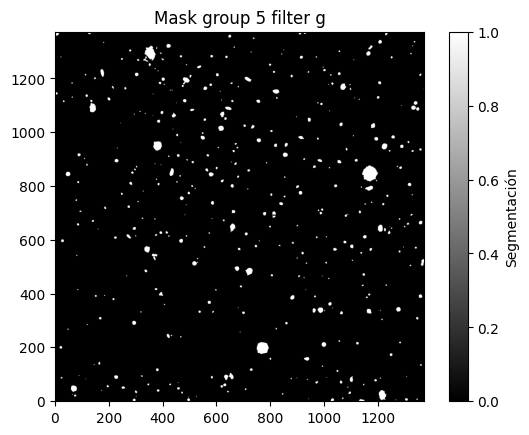

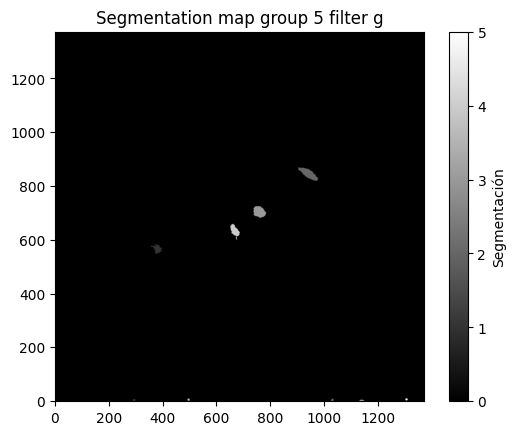

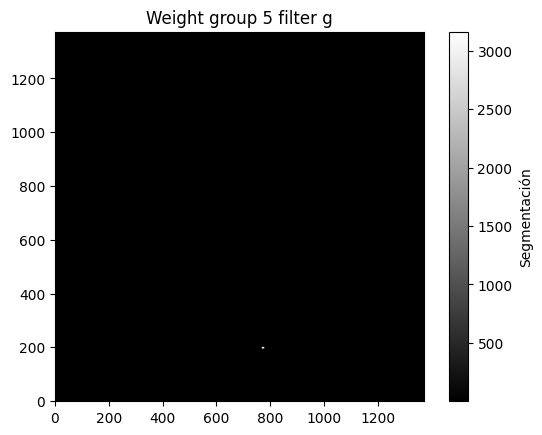

Time: 127.484 s.


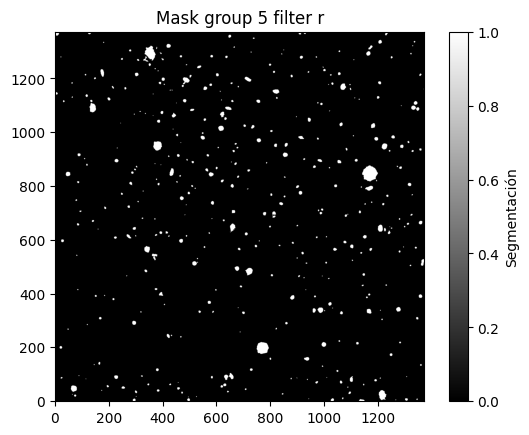

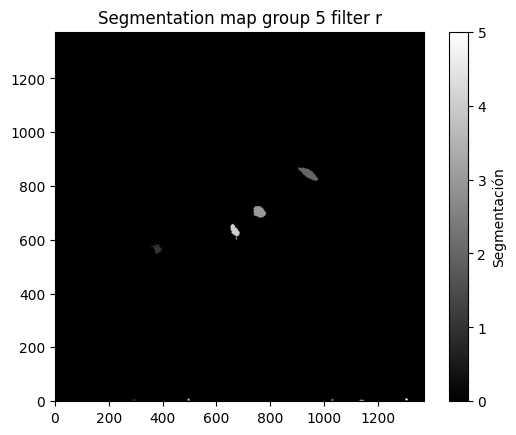

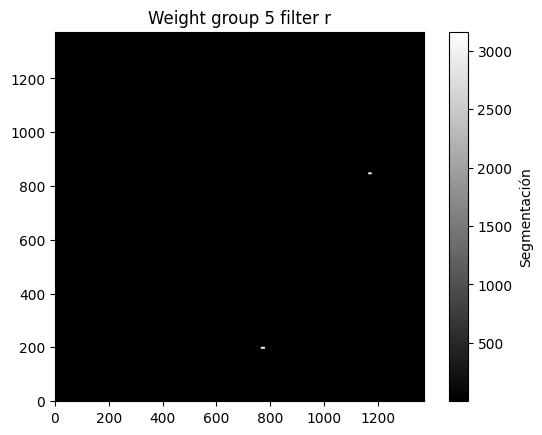

Time: 203.593 s.


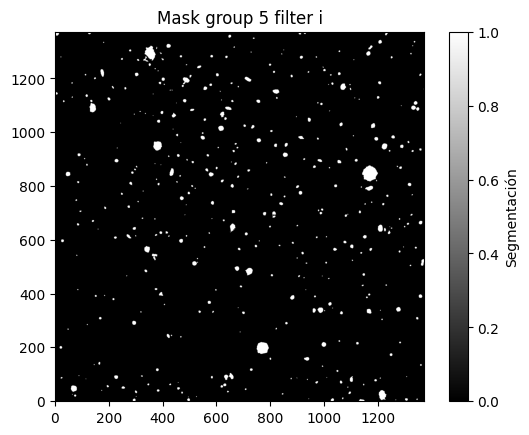

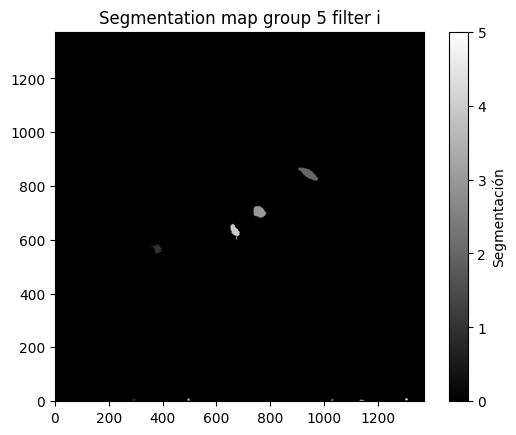

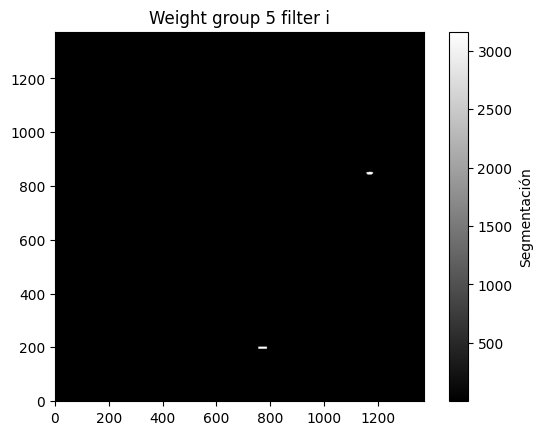

Time: 268.3 s.


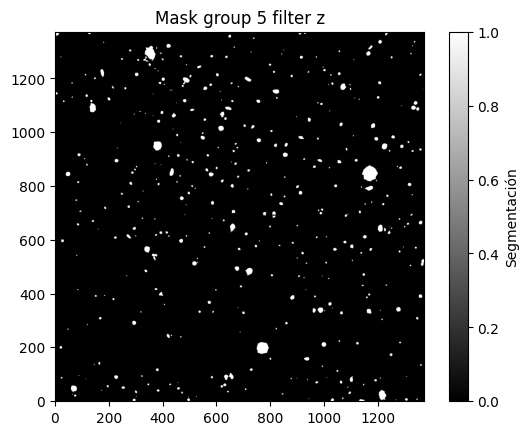

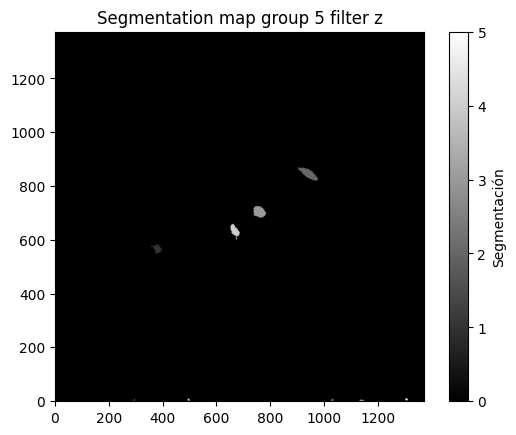

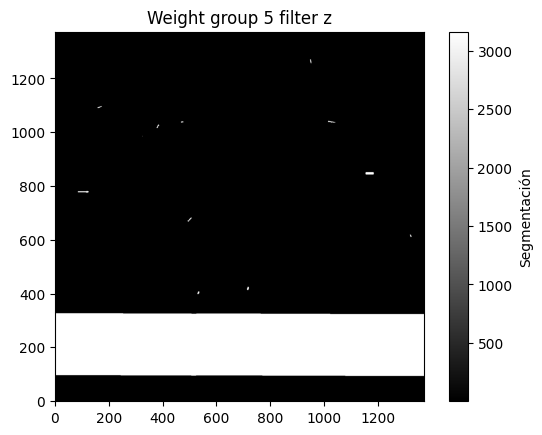

Time: 230.757 s.


In [31]:
groups = [5]#, 3]#, 4, 5, 7, 8, 10, 11, 13, 14]

morphs = []
for grupo in groups:
    filtros = filter_sel(grupo)[0]
    segmap_grupo = segmentation(grupo)
    for filtro in filtros:
        morphs.append(morph(grupo, filtro, segmap_grupo))

In [42]:
for i in range(len(morphs)):
    morph = morphs[i][4]
    print(morph.flag)

1
1
1
1
1
1
4
2
1
2
1
2
2
2
4
2
1
1
2
2
1
2
1
2
1
1
2
1
1
1
1
2
2
1
2
0
1
2
1


In [209]:
hdu_image = fits.open('/home/seba/Documents/DECALS/joined_bricks/235/235_image_r.fits')
image = hdu_image[0].data

hdu_weight = fits.open('/home/seba/Documents/DECALS/sigma_image/235/sigma_235_weight_r.fits')
weight = hdu_weight[0].data

hdu_segmap = fits.open('/home/seba/Documents/MorphoLS/Field_Img/det/det_group_235_seg.fits')
segmap = hdu_segmap[0].data

hdu_mask = fits.open('/home/seba/Documents/MorphoLS/Field_Img/mask/mask_group_235.fits')
mask = hdu_mask[0].data

hdu_psf = fits.open('/home/seba/Documents/MorphoLS/Field_Img/psf/psf_group_235_r.fits')
psf = hdu_psf[0].data

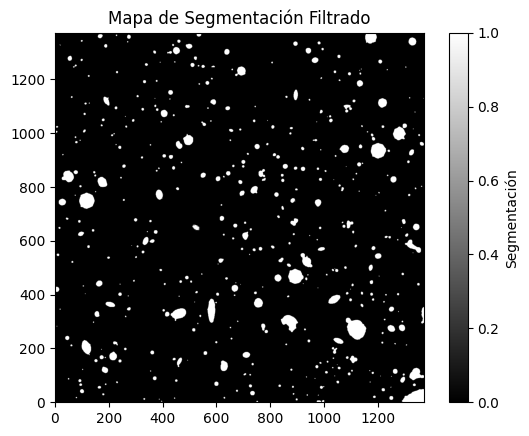

In [200]:
# Visualizar el mapa de segmentación desenmascarado
plt.imshow(mask, origin='lower', cmap='gray')
plt.colorbar(label='Segmentación')
plt.title('Mapa de Segmentación Filtrado')
plt.show()

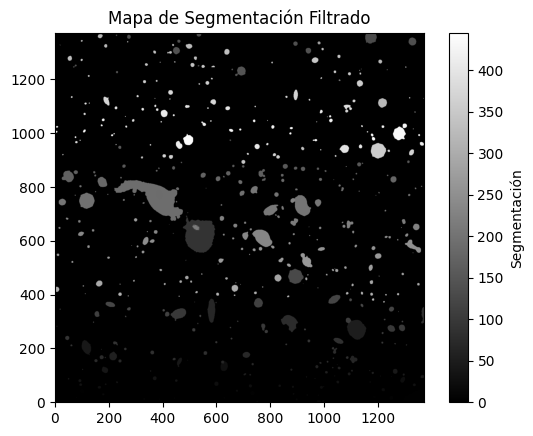

In [204]:
# Visualizar el mapa de segmentación desenmascarado
plt.imshow(segmap, origin='lower', cmap='gray')
plt.colorbar(label='Segmentación')
plt.title('Mapa de Segmentación Filtrado')
plt.show()

## Segmentation Image

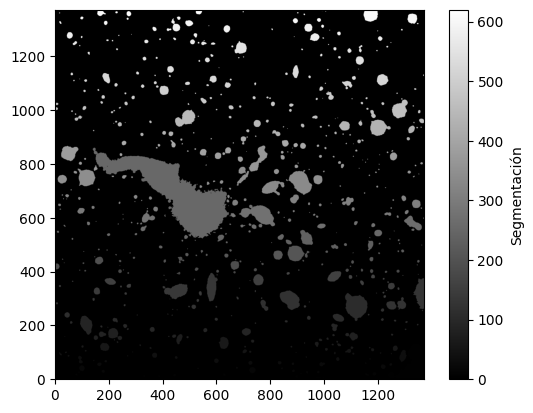

In [195]:
threshold = detect_threshold(image, 1.5)
npixels = 5  # minimum number of connected pixels
convolved_image = convolve(image, psf)
segmap = detect_sources(convolved_image, threshold, npixels)
plt.imshow(segmap.data, origin='lower', cmap='gray')
plt.colorbar(label='Segmentación')

In [192]:
X

array([535.4581, 407.4114, 915.3221, 802.1036, 773.4702])

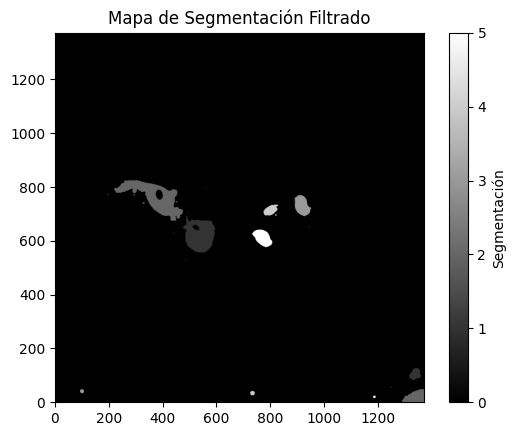

In [211]:
Gal_se = Table.read(f'sex/Groups/Galaxies_group_235.csv')
X=np.array(Gal_se['X_IMAGE'])
Y=np.array(Gal_se['Y_IMAGE'])

count = 1
#Desenmascarar todo lo que no sea de interés
for i in range(len(X)):
    arr_mask = segmap == segmap[int(Y[i])][int(X[i])]
    segmap[arr_mask] = count
    count += 1
arr_mask = (segmap != 1) & (segmap != 2) & (segmap != 3) & (segmap != 4) & (segmap != 5)  
segmap[arr_mask] = 0
segmap_new_hdu = fits.PrimaryHDU(segmap)
segmap_new = segmap_new_hdu.data

# Visualizar el mapa de segmentación desenmascarado
plt.imshow(segmap_new, origin='lower', cmap='gray')
plt.colorbar(label='Segmentación')
plt.title('Mapa de Segmentación Filtrado')
plt.show()

In [87]:
hdu_image_cs = fits.open('/home/seba/Documents/DECALS/joined_bricks_cs/135/135_image_r.fits')
image_cs = hdu_image_cs[0].data

hdu_weight_cs = fits.open('/home/seba/Documents/DECALS/sigma_image_cs/135/sigma_135_weight_r.fits')
weight_cs = hdu_weight_cs[0].data

hdu_segmap_cs = fits.open('/home/seba/Documents/MorphoLS/Field_Img/det_cs/det_galaxy_135_seg.fits')
segmap_cs = hdu_segmap_cs[0].data

hdu_mask_cs = fits.open('/home/seba/Documents/MorphoLS/Field_Img/mask_cs/mask_galaxy_135.fits')
mask_cs = hdu_mask_cs[0].data

hdu_psf_cs = fits.open('/home/seba/Documents/MorphoLS/Field_Img/psf_cs/psf_galaxy_135_r.fits')
psf_cs = hdu_psf_cs[0].data

In [212]:
mask = mask.astype(np.bool_)
mask_cs = mask_cs.astype(np.bool_)

print(mask.dtype)

bool


In [213]:
start = time.time()
source_morphs = statmorph.source_morphology(
    image, segmap=segmap_new, weightmap=weight, mask=mask, psf=psf)
print('Time: %g s.' % (time.time() - start))

Time: 370.799 s.


In [217]:
morph_1 = source_morphs[0]
morph_2 = source_morphs[1]
morph_3 = source_morphs[2]
morph_4 = source_morphs[3]
morph_5 = source_morphs[4]

In [60]:
print(f"Min value: {image.min()}, Max value: {image.max()}, Mean: {image.mean()}")
print(f"Min value: {image_cs.min()}, Max value: {image_cs.max()}, Mean: {image_cs.mean()}")


Min value: -0.014006844357252152, Max value: 25.179591263723562, Mean: 0.006946753305038049
Min value: -0.018732421358287794, Max value: 7.786371204144363, Mean: 0.0036607492709821937


/tmp/ipykernel_3223/1050860955.py:2: RuntimeWarning: divide by zero encountered in log
  scaled_image = np.log(image)
/tmp/ipykernel_3223/1050860955.py:2: RuntimeWarning: invalid value encountered in log
  scaled_image = np.log(image)


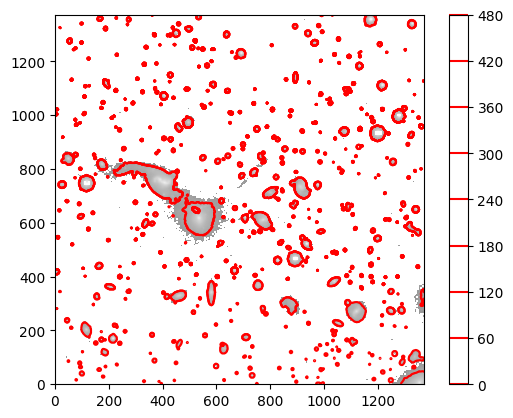

In [173]:
# Aplica la transformación asinh a la imagen
scaled_image = np.log(image)

# Visualiza la imagen con la escala asinh
plt.imshow(scaled_image, origin='lower', cmap='gray')
plt.contour(segmap.data, colors='red')
plt.colorbar()  # Añadir una barra de color para visualizar la escala
plt.show()


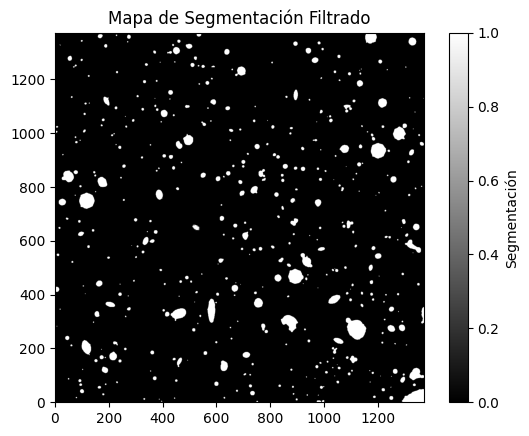

In [174]:
# Visualizar el mapa de segmentación desenmascarado
plt.imshow(mask, origin='lower', cmap='gray')
plt.colorbar(label='Segmentación')
plt.title('Mapa de Segmentación Filtrado')
plt.show()

In [219]:
print('Gini =', morph.gini)
print('flag =', morph_1.flag, morph_2.flag, morph_3.flag, morph_4.flag, morph_5.flag)


Gini = 0.5674598547711928
flag = 0 2 2 1 2


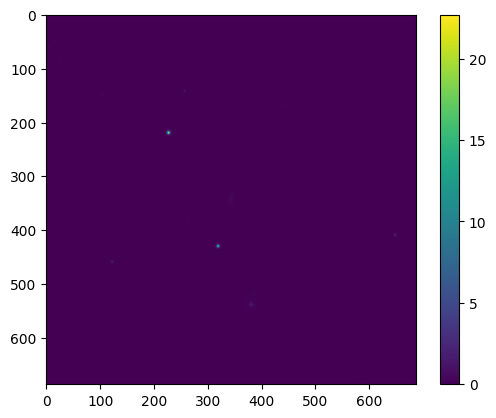

In [22]:
plt.imshow(image)
plt.colorbar()

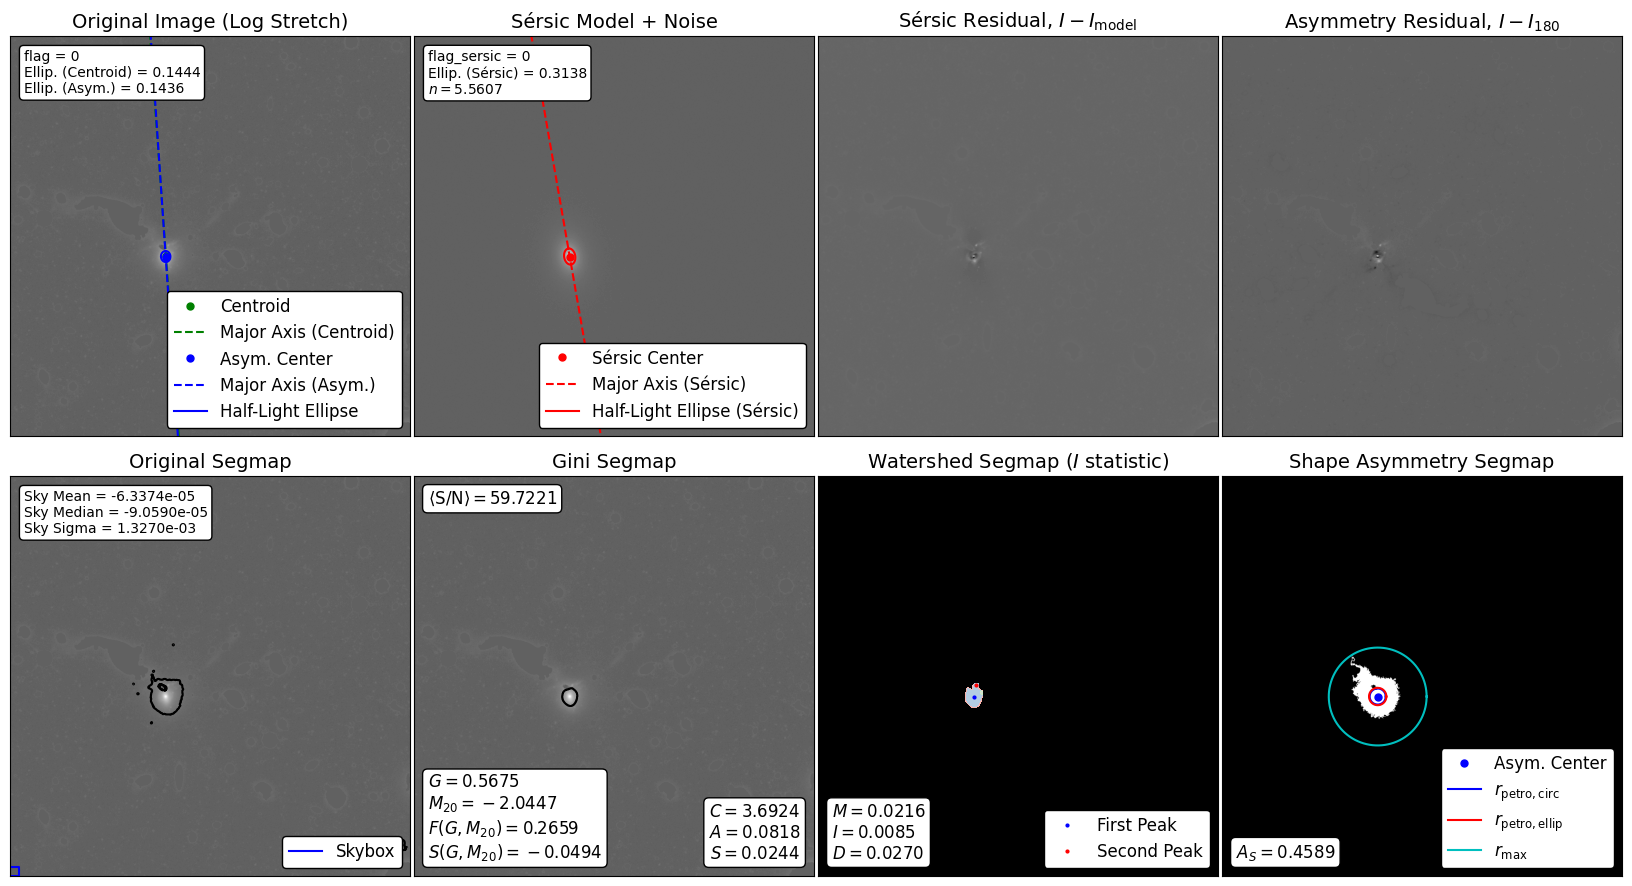

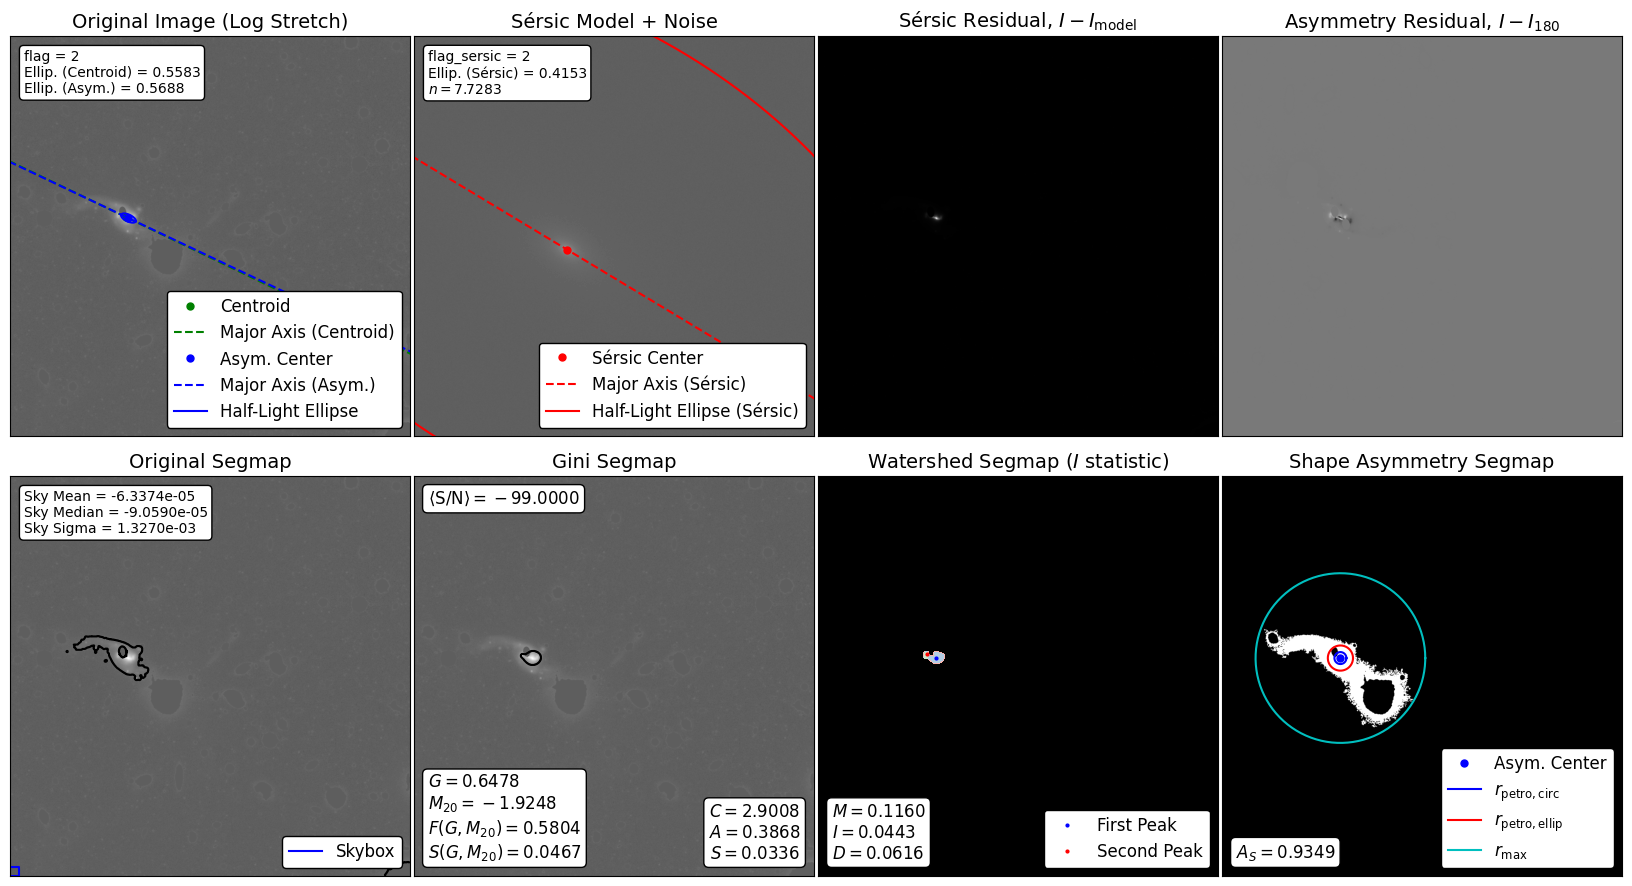

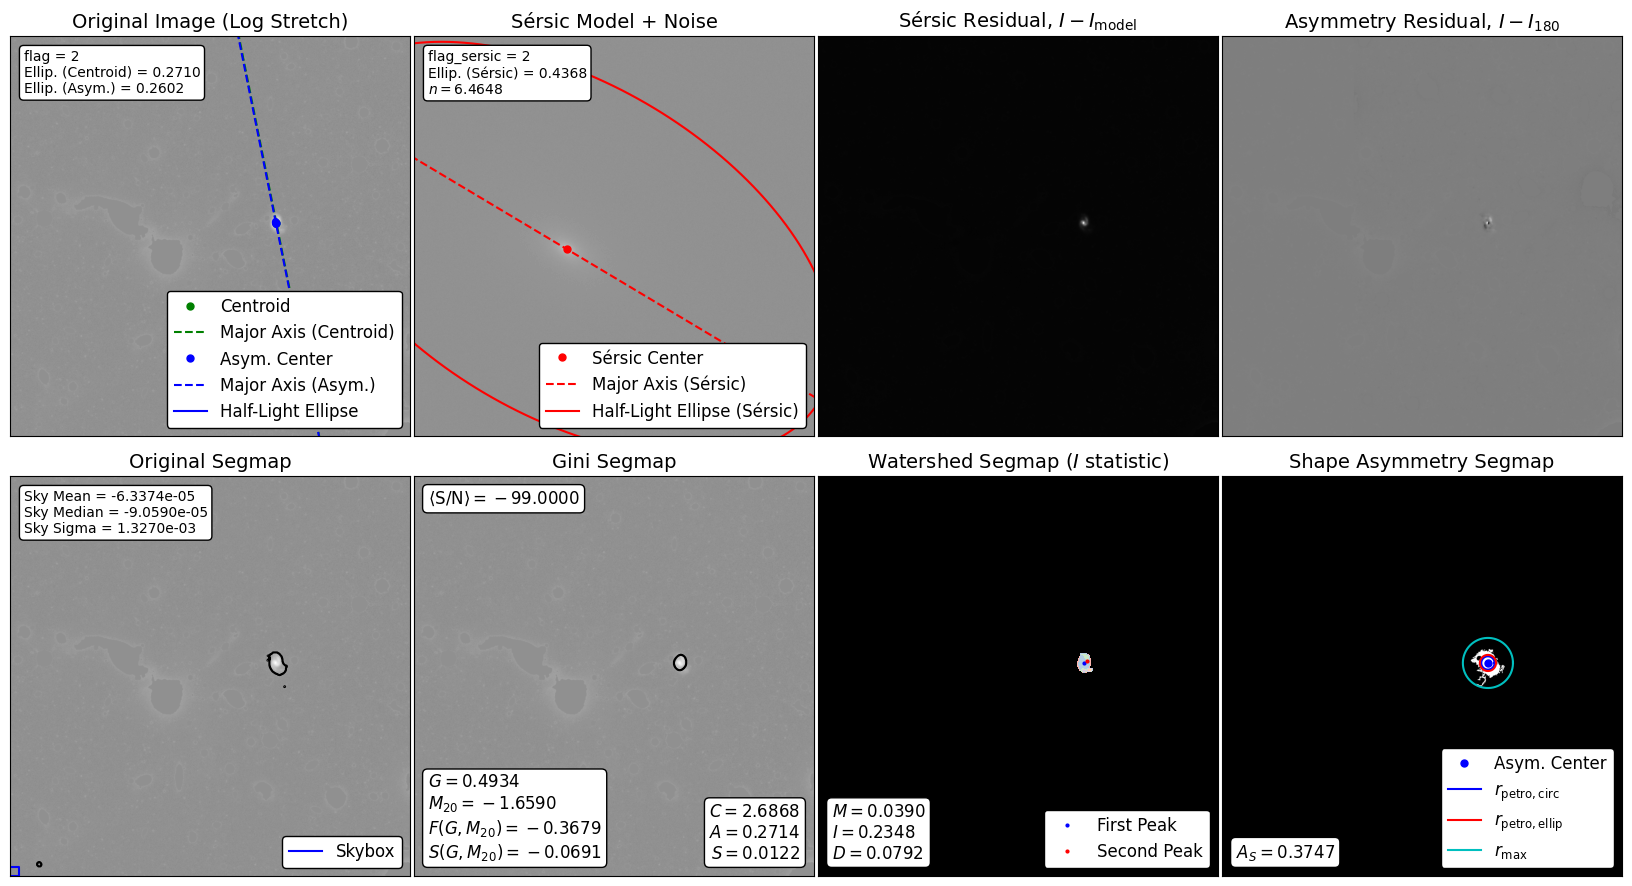

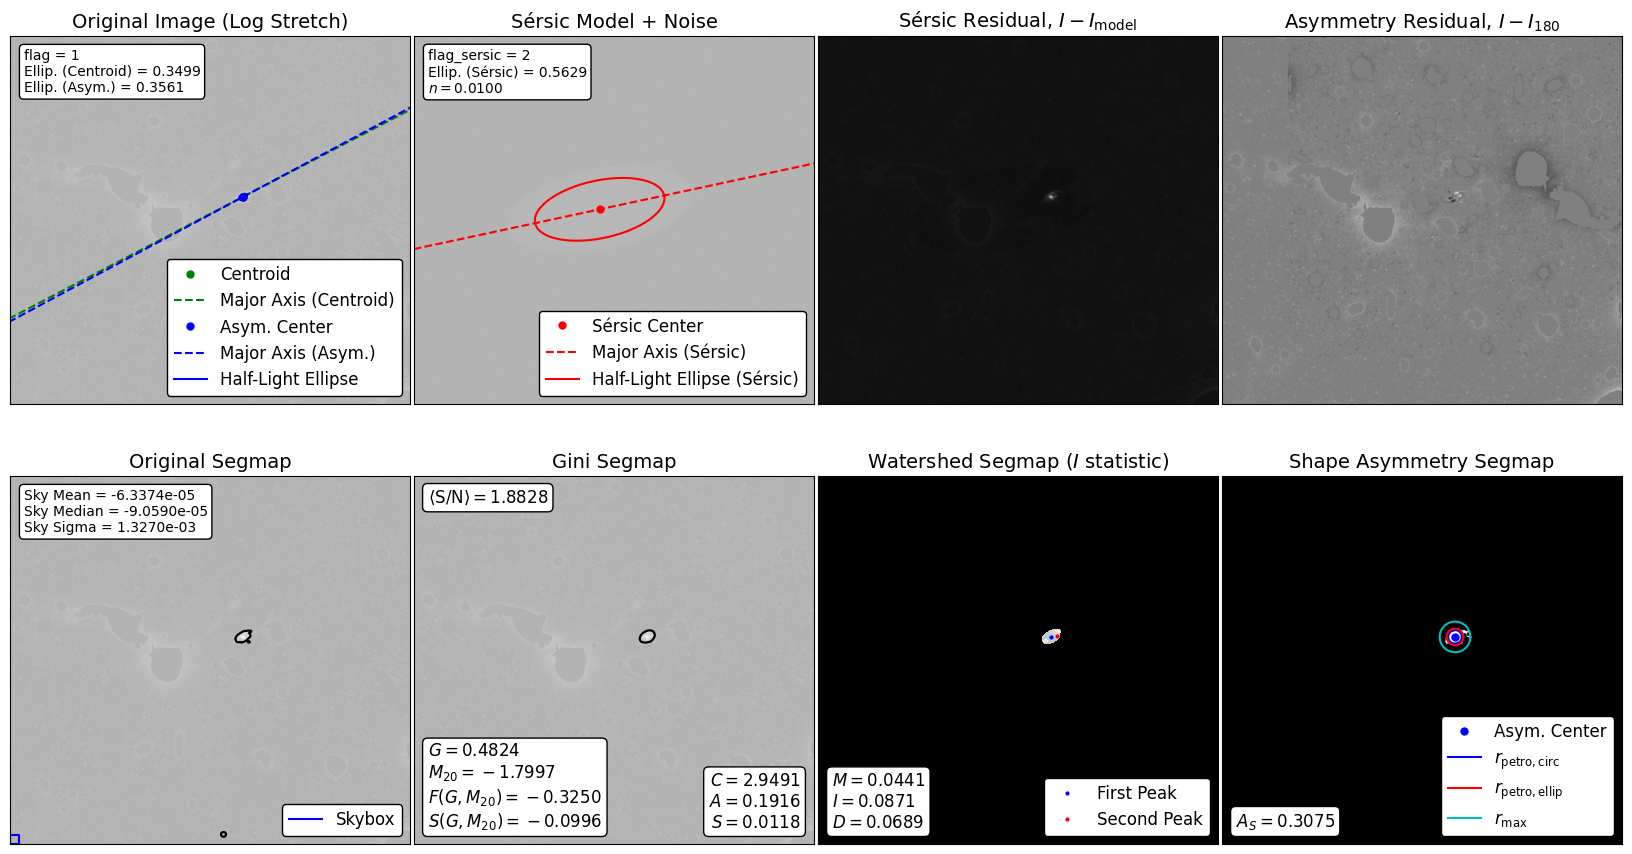

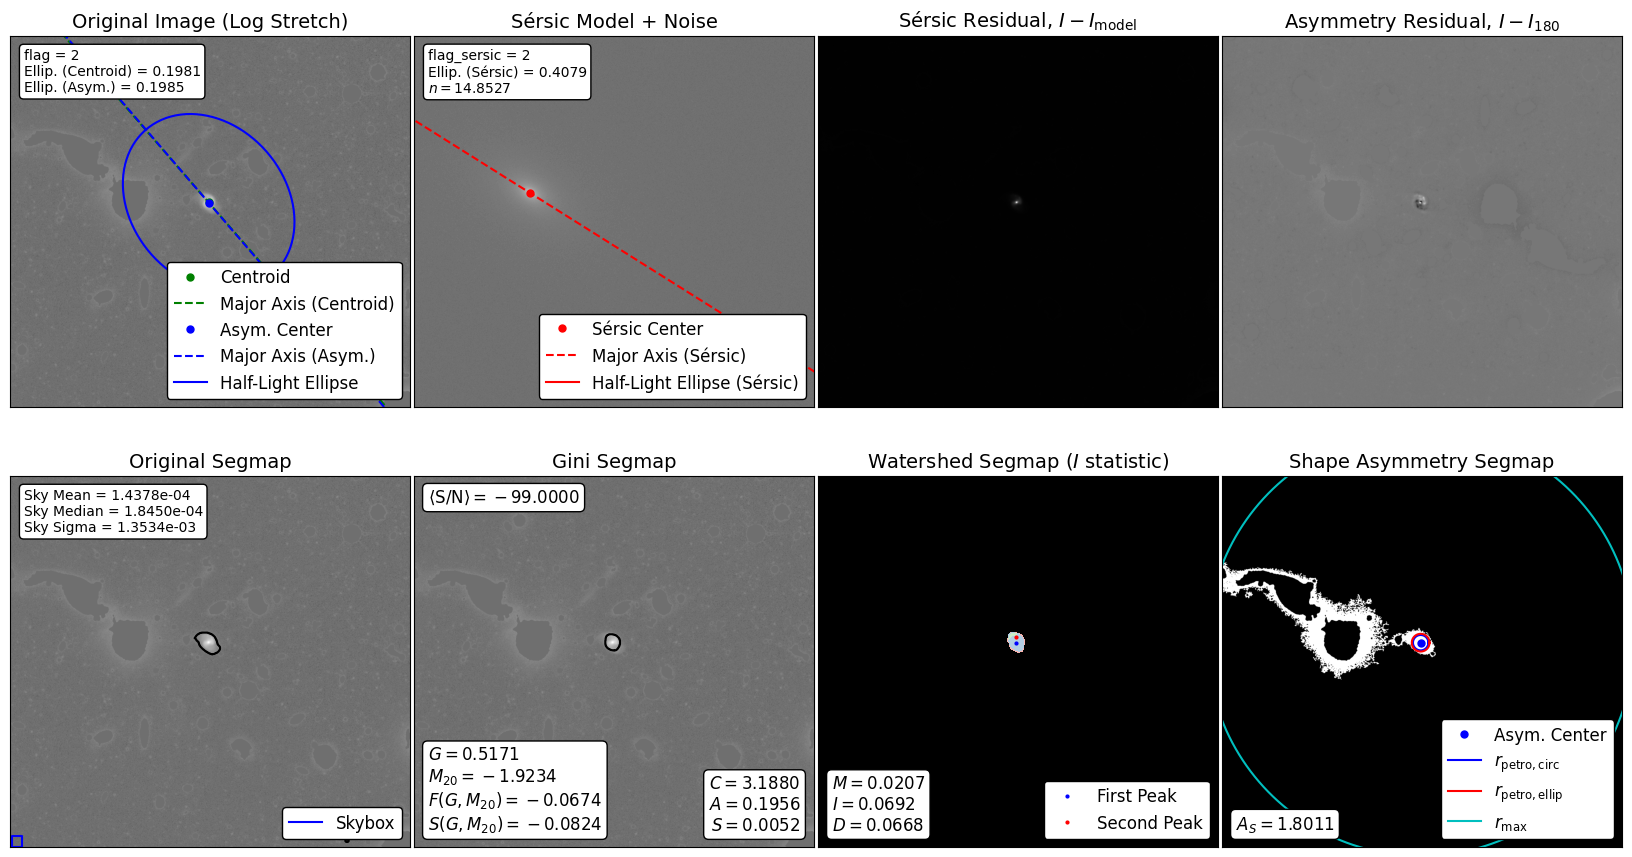

In [218]:
from statmorph.utils.image_diagnostics import make_figure
fig_1 = make_figure(morph_1)
fig_2 = make_figure(morph_2)
fig_3 = make_figure(morph_3)
fig_4 = make_figure(morph_4)
fig_5 = make_figure(morph_5)

Text(-0.7, 0.62, 'Mergers')

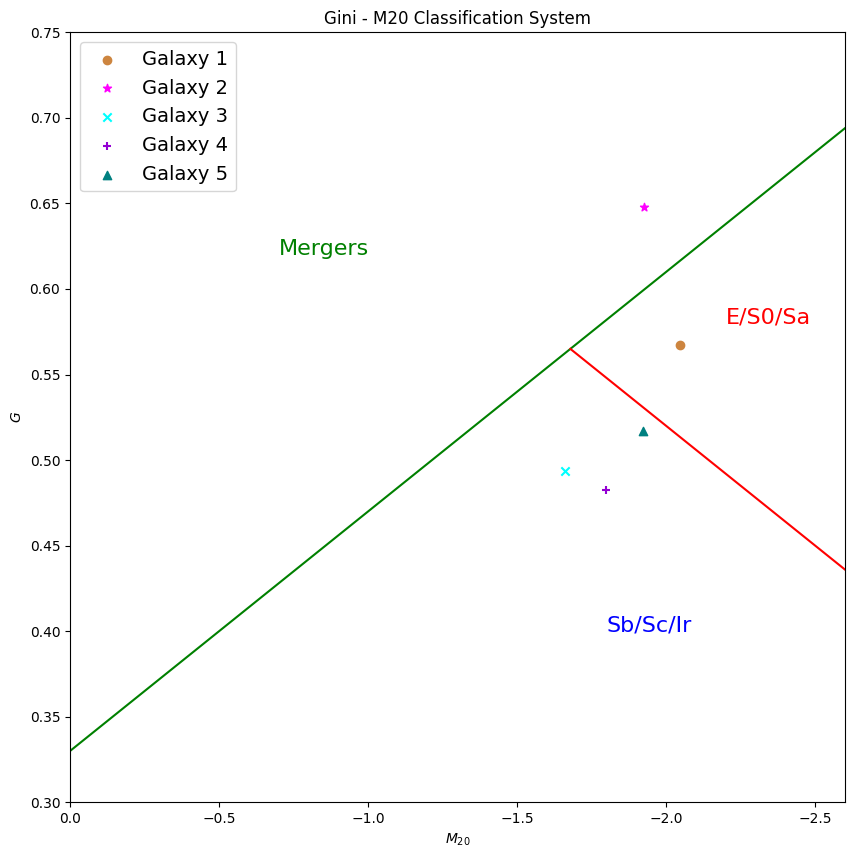

In [224]:
gini_gal_1 = morph_1.gini
gini_gal_2 = morph_2.gini
gini_gal_3 = morph_3.gini
gini_gal_4 = morph_4.gini
gini_gal_5 = morph_5.gini

ginis = [gini_gal_1, gini_gal_2, gini_gal_3, gini_gal_4, gini_gal_5]

m20_gal_1 = morph_1.m20
m20_gal_2 = morph_2.m20
m20_gal_3 = morph_3.m20
m20_gal_4 = morph_4.m20
m20_gal_5 = morph_5.m20

m20s = [m20_gal_1, m20_gal_2, m20_gal_3, m20_gal_4, m20_gal_5]

lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-2.6, 0, 100)
x_line_2 = np.linspace(-2.6, lim_2, 100)
y_line_1 = -0.14*x_line_1 + 0.33
y_line_2 = 0.14*x_line_2 + 0.80

colors = ['peru', 'magenta', 'cyan', 'darkviolet', 'teal']

markers = ['o', '*', 'x', '+', '^']

labels = ['Galaxy 1', 'Galaxy 2', 'Galaxy 3', 'Galaxy 4', 'Galaxy 5']

plt.figure(figsize=(10, 10))

plt.plot(x_line_1, y_line_1, color='green')
plt.plot(x_line_2, y_line_2, color='red')

# Aquí plotea tus galaxias
for i in range(len(m20s)):
    plt.scatter(m20s[i], ginis[i], color=colors[i], marker=markers[i], label=labels[i])

plt.xlim(0, -2.6)
plt.ylim(0.3, 0.75)
plt.xlabel(r'$M_{20}$')
plt.ylabel(r'$G$')
plt.title('Gini - M20 Classification System')
plt.legend(fontsize=14)

plt.text(-2.2, 0.58, 'E/S0/Sa', fontsize=16, color='red')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='blue')
plt.text(-0.7, 0.62, 'Mergers', fontsize=16, color='green')

In [14]:
parameters = Table.read('/home/seba/Downloads/DECALS_Astromorphlib.csv', format='ascii')
parameters = parameters[(parameters['Gini'] != 0.0) & (parameters['M20'] != 0.0)]

       Gini       
------------------
0.6033777322277729
0.5552932161637162
0.4252600369399373
0.6739555437613641
0.6033777322277729
0.6739555437613641
0.4252600369399373
               ...
0.6739555437613641
0.4252600369399373
0.5552932161637162
0.4252600369399373
0.6739555437613641
0.6033777322277729
0.5552932161637162
Length = 875 rows         M20        
-------------------
-1.9832306089304703
-1.9961358578727664
-1.6515851749749102
 -2.002405167988392
-1.9832306089304703
 -2.002405167988392
-1.6515851749749102
                ...
 -2.002405167988392
-1.6515851749749102
-1.9961358578727664
-1.6515851749749102
 -2.002405167988392
-1.9832306089304703
-1.9961358578727664
Length = 875 rows


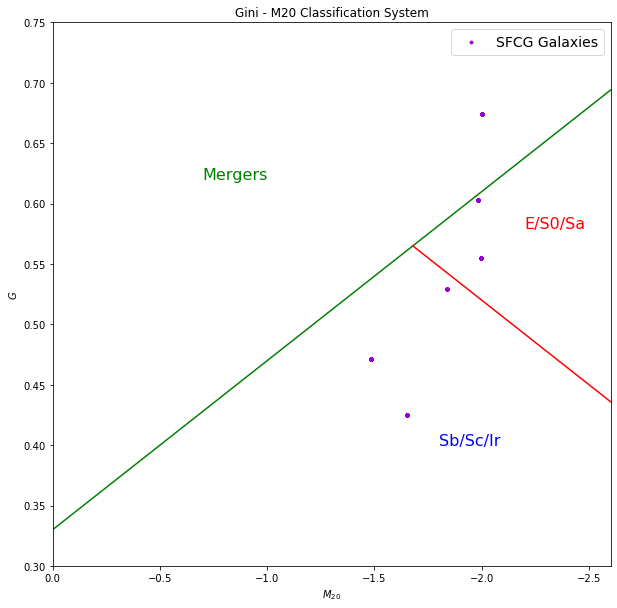

In [20]:
ginis = parameters['Gini']

m20s = parameters['M20']
print(ginis, m20s)
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-2.6, 0, 100)
x_line_2 = np.linspace(-2.6, lim_2, 100)
y_line_1 = -0.14*x_line_1 + 0.33
y_line_2 = 0.14*x_line_2 + 0.80

plt.figure(figsize=(10, 10))

plt.plot(x_line_1, y_line_1, color='green')
plt.plot(x_line_2, y_line_2, color='red')

plt.scatter(m20s, ginis, color='darkviolet', label='SFCG Galaxies', s=8)

plt.xlim(0, -2.6)
plt.ylim(0.3, 0.75)
plt.xlabel(r'$M_{20}$')
plt.ylabel(r'$G$')
plt.title('Gini - M20 Classification System')
plt.legend(fontsize=14)

plt.text(-2.2, 0.58, 'E/S0/Sa', fontsize=16, color='red')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='blue')
plt.text(-0.7, 0.62, 'Mergers', fontsize=16, color='green')
plt.show()
